In [1]:
import numpy as np
from numpy import array
import os
import re
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.constraints import maxnorm

### Cargamos las imagenes del dataset

In [2]:
# Obtenemos la dirección donde está nuestro dataset y cargamos las imagenes
def carga(carpeta, showD = False):
    """
    Este método recibe el nombre de la sub-carpeta de "doc" donde están las imagenes que bamos a cargar. Guearda
    las imagenes a color e ignora todas las imagenes en grises.
    :param carpeta: Nombre de la carpeta donde están las imagenes que cargaremos
    :param showD: Si es 'True' despliega el diccionario con la equivalencia salida-Deporte(por default es False)  
    """
    dire = os.getcwd()[:-3]
    c = "data\\" + carpeta
    dirname = os.path.join(dire, c)
    imgpath = dirname + os.sep

    images = []
    directories = []
    dircount = []
    prevRoot=''
    cant=0

    # Cargamos las imágenes
    print("leyendo imagenes de ",imgpath,"\n")

    for root, dirnames, filenames in os.walk(imgpath):
        for filename in filenames:
            if re.search("\.(jpg)$", filename):
                cant=cant+1
                filepath = os.path.join(root, filename)
                image = plt.imread(filepath)
                if len(np.shape(image)) == 3:
                    images.append(image)
                else:
                    cant-=1
                b = "Leyendo..." + str(cant)
                print (b, end="\r")
                if prevRoot !=root:
                    print("Cargado: {0}".format(root))
                    prevRoot=root
                    directories.append(root)
                    dircount.append(cant)
                    cant=0
    dircount.append(cant)
    print(" ",end="\r")
    dircount = dircount[1:]
    dircount[len(directories)-1]=dircount[len(directories)-1]+1

    print('Carpetas leidas:',len(directories))
    print('Total de imagenes:',sum(dircount))
    
    #Damos formato a la salida X
    X = array(images, dtype=np.uint8)/255
    
    # Clasificando y etiquetando las entradas
    etiquetas = []
    indice = 0
    for cantidad in dircount:
        for i in range(cantidad):
            etiquetas.append(indice)
        indice=indice+1
    
    diccionario = []
    deportes=[]
    indice = 0
    for directorio in directories:
        name = directorio.split(os.sep)
        defin = str(indice)+"-"+name[len(name)-1]
        #print(indice , name[len(name)-1])
        diccionario.append(defin)
        deportes.append(name[len(name)-1])
        indice=indice+1
    
    #Damos formato a la salida y
    y = np.array(etiquetas).astype('float32')

    print('Número total de clases: ', len(np.unique(y)))
    if showD:
        print("Diccionario:")
        for p in diccionario:
            print("",p)

    return X, y, diccionario

#### Si queremos entrenar la red entre 5 categorias:
    Las carpetas a cargar serán "train" y "test" respectivamente.
#### Si queremos entrenar la red entre 50 categorias:
    Las carpetas a cargar serán "train(50)" y "test(50)" respectivamente.
        (Aunque esta me tardó 2hrs en mi computadora)
#### Si queremos entrenar la red entre 100 categorias:
    Las carpetas a cargar serán "train(100)" y "test(100)" respectivamente.
        (Esta pasmó mi computadora así que ya no supe cuanto tardaría)

In [3]:
# Cargamos las imagenes para el entrenamiento
Xe, Ye, diccionarioE = carga('train', showD = True)

leyendo imagenes de  C:\Users\PC\OneDrive\Documentos\Proyectos CC\Proyecto\ProyectoRN\data\train\ 

Cargado: C:\Users\PC\OneDrive\Documentos\Proyectos CC\Proyecto\ProyectoRN\data\train\baseball
Cargado: C:\Users\PC\OneDrive\Documentos\Proyectos CC\Proyecto\ProyectoRN\data\train\basketball
Cargado: C:\Users\PC\OneDrive\Documentos\Proyectos CC\Proyecto\ProyectoRN\data\train\boxing
Cargado: C:\Users\PC\OneDrive\Documentos\Proyectos CC\Proyecto\ProyectoRN\data\train\football
Cargado: C:\Users\PC\OneDrive\Documentos\Proyectos CC\Proyecto\ProyectoRN\data\train\hockey
Carpetas leidas: 5
Total de imagenes: 821
Número total de clases:  5
Diccionario:
 0-baseball
 1-basketball
 2-boxing
 3-football
 4-hockey


In [4]:
# Cargamos las imagenes para el test
Xp, Yp, diccionarioT = carga('test')

# Verificamos si nuestros diccionarios coinciden
if diccionarioE == diccionarioT:
    print("\t--Los diccionarios coinciden puede continuar")
else:
    print("\t--Hay una diferencia en los diccionarios, verifiquelo")

leyendo imagenes de  C:\Users\PC\OneDrive\Documentos\Proyectos CC\Proyecto\ProyectoRN\data\test\ 

Cargado: C:\Users\PC\OneDrive\Documentos\Proyectos CC\Proyecto\ProyectoRN\data\test\baseball
Cargado: C:\Users\PC\OneDrive\Documentos\Proyectos CC\Proyecto\ProyectoRN\data\test\basketball
Cargado: C:\Users\PC\OneDrive\Documentos\Proyectos CC\Proyecto\ProyectoRN\data\test\boxing
Cargado: C:\Users\PC\OneDrive\Documentos\Proyectos CC\Proyecto\ProyectoRN\data\test\football
Cargado: C:\Users\PC\OneDrive\Documentos\Proyectos CC\Proyecto\ProyectoRN\data\test\hockey
Carpetas leidas: 5
Total de imagenes: 25
Número total de clases:  5
	--Los diccionarios coinciden puede continuar


### Obtenemos nuestros conjuntos de Entrenamiento, prueva y validación

#### Definimos nuestros modelos

In [6]:
INIT_LR = 1e-3
epochs = 16
batch_size = 64
inShape = np.shape(Xp[0])
nClasses=len(diccionarioE)

In [8]:
# Modelo 1, un modelo pequeño, pasa sólo por un filtro, 1 puling, y 2 capas densas
modelo1 = Sequential()
modelo1.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=inShape))
modelo1.add(LeakyReLU(alpha=0.1))
modelo1.add(MaxPooling2D((2, 2),padding='same'))
modelo1.add(Dropout(0.5))
 
modelo1.add(Flatten())
modelo1.add(Dense(32, activation='linear'))
modelo1.add(LeakyReLU(alpha=0.1))
modelo1.add(Dropout(0.5)) 
modelo1.add(Dense(nClasses, activation='softmax'))
 
modelo1.summary()

#modelo1.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adagrad(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])
modelo1.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 flatten_1 (Flatten)         (None, 401408)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                12845088  
                                                      

In [9]:
# Modelo 2, tiene 3 filtros, 1 pulida y 3 capas densas
modelo2 = Sequential()
modelo2.add(Conv2D(32, (3, 3), input_shape=inShape, activation='linear', padding='same'))
modelo1.add(LeakyReLU(alpha=0.1))

modelo2.add(Conv2D(32, (3, 3), activation='linear', padding='same'))
modelo1.add(LeakyReLU(alpha=0.1))

modelo2.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
modelo2.add(MaxPooling2D(pool_size=(2, 2)))
modelo2.add(Dropout(0.5))

modelo2.add(Flatten())

modelo2.add(Dense(64, activation='linear'))
modelo2.add(LeakyReLU(alpha=0.1))
modelo2.add(Dropout(0.5))
modelo2.add(BatchNormalization())

modelo2.add(Dense(32, activation='linear'))
modelo1.add(LeakyReLU(alpha=0.1))
modelo2.add(Dropout(0.5))

modelo2.add(Dense(nClasses))
modelo2.add(Activation('softmax'))

optimizer="adam"

modelo2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

print(modelo2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 flatten_2 (Flatten)         (None, 802816)            0         
                                                      

### >>>Si queremos evaluar cada modelo por separado usamos estas celdas

In [10]:
# Cargamos nuestras listas
train_X, train_Y = Xe, Ye
test_X, test_Y = Xp, Yp 

# Cambiamos el formato de los valores esperados a one-hot
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

#Separamos el conjunto de validación de el de entrenamiento
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2)
print("Tamaño del conjunto de entrenamiento:", len(train_X))
print("Tamaño del conjunto de validación:",len(valid_X))
print("Tamaño del conjunto de prueba:",len(test_X))

Tamaño del conjunto de entrenamiento: 656
Tamaño del conjunto de validación: 165
Tamaño del conjunto de prueba: 25


        Entrenamiento del Modelo 1

Epoch 1/16
11/11 [==============================] - 11s 942ms/step - loss: 11.4515 - accuracy: 0.2012 - val_loss: 12.0027 - val_accuracy: 0.2303
Epoch 2/16
11/11 [==============================] - 10s 926ms/step - loss: 10.7263 - accuracy: 0.2805 - val_loss: 7.7780 - val_accuracy: 0.2424
Epoch 3/16
11/11 [==============================] - 10s 928ms/step - loss: 3.5925 - accuracy: 0.3720 - val_loss: 1.6231 - val_accuracy: 0.4061
Epoch 4/16
11/11 [==============================] - 10s 927ms/step - loss: 1.7691 - accuracy: 0.4482 - val_loss: 1.1732 - val_accuracy: 0.5939
Epoch 5/16
11/11 [==============================] - 10s 928ms/step - loss: 1.1783 - accuracy: 0.5732 - val_loss: 0.9994 - val_accuracy: 0.6303
Epoch 6/16
11/11 [==============================] - 10s 932ms/step - loss: 0.8018 - accuracy: 0.7073 - val_loss: 1.0599 - val_accuracy: 0.6000
Epoch 7/16
11/11 [==============================] - 10s 925ms/step - loss: 0.5677 - accuracy: 0.7912 - val_loss: 0.9511 - val_accuracy: 0.6

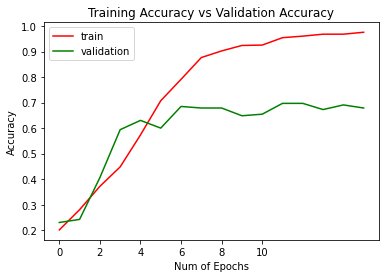

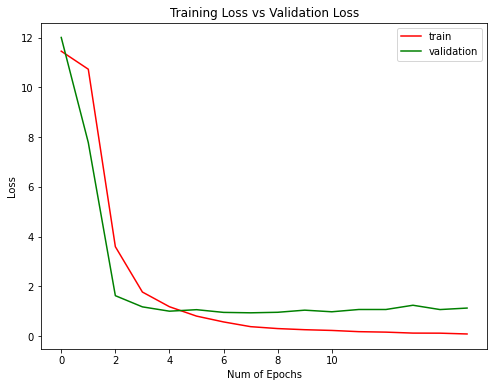

In [11]:
sports_categorizer = modelo1.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

# Guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
modelo1.save("modelo1.h5py")

plt.figure(0)  
plt.plot(sports_categorizer.history['accuracy'],'r')  
plt.plot(sports_categorizer.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(sports_categorizer.history['loss'],'r')  
plt.plot(sports_categorizer.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

        Entrenamiento del Modelo 2

Epoch 1/16
11/11 [==============================] - 59s 5s/step - loss: 2.3970 - accuracy: 0.2515 - val_loss: 9.2805 - val_accuracy: 0.3091
Epoch 2/16
11/11 [==============================] - 59s 5s/step - loss: 2.0872 - accuracy: 0.3018 - val_loss: 5.8491 - val_accuracy: 0.2303
Epoch 3/16
11/11 [==============================] - 57s 5s/step - loss: 2.0436 - accuracy: 0.3095 - val_loss: 5.9870 - val_accuracy: 0.2364
Epoch 4/16
11/11 [==============================] - 57s 5s/step - loss: 1.6474 - accuracy: 0.4177 - val_loss: 1.3047 - val_accuracy: 0.5455
Epoch 5/16
11/11 [==============================] - 58s 5s/step - loss: 1.5974 - accuracy: 0.4527 - val_loss: 3.3925 - val_accuracy: 0.1879
Epoch 6/16
11/11 [==============================] - 58s 5s/step - loss: 1.4506 - accuracy: 0.4619 - val_loss: 1.1846 - val_accuracy: 0.4788
Epoch 7/16
11/11 [==============================] - 58s 5s/step - loss: 1.3447 - accuracy: 0.5030 - val_loss: 0.9461 - val_accuracy: 0.6424
Epoch 8/16
11/11 [==

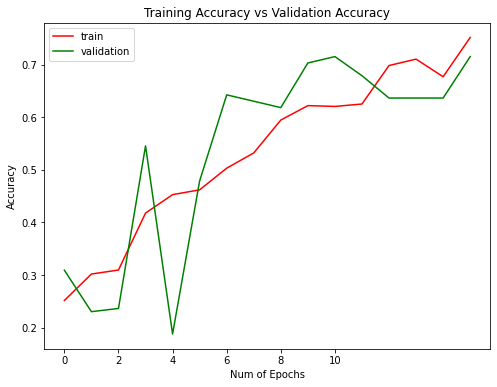

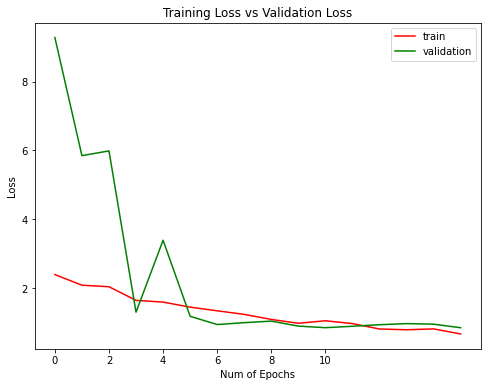

In [12]:
sports_categorizer = modelo2.fit(train_X, train_label, batch_size=batch_size,
                                 epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
# Guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
modelo2.save("modelo2.h5py")

plt.figure(0)  
plt.plot(sports_categorizer.history['accuracy'],'r')  
plt.plot(sports_categorizer.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(sports_categorizer.history['loss'],'r')  
plt.plot(sports_categorizer.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

#### Usamos los modelos con nuestro conjunto de prueba

In [13]:
scores = modelo1.evaluate(test_X, test_Y_one_hot)
res1 = "\tModelo1.- A="+str(round((scores[1]*100),8))+"%, P="+str(round(scores[0],8))
print("Accuracy: %.2f%%" % (scores[1]*100))
print('Perdida:', scores[0])

1/1 [==============================] - 0s 62ms/step - loss: 0.8275 - accuracy: 0.8000
Accuracy: 80.00%
Perdida: 0.827454686164856


In [14]:
scores = modelo2.evaluate(test_X, test_Y_one_hot)
res2 = "\tModelo2.- A="+str(round((scores[1]*100),8))+"%, P="+str(round(scores[0],8))
print("Accuracy: %.2f%%" % (scores[1]*100))
print('Perdida:', scores[0])

1/1 [==============================] - 0s 252ms/step - loss: 0.6319 - accuracy: 0.7600
Accuracy: 76.00%
Perdida: 0.631852924823761


In [15]:
print("----"*15,"\n",res1,"\n",res2)

------------------------------------------------------------ 
 	Modelo1.- A=80.00000119%, P=0.82745469 
 	Modelo2.- A=75.99999905%, P=0.63185292


### >>>Si queremos entrenar varias veces ambos modelos usamos estas otras

In [16]:
def entrenaModelo(modelo):
    """
    Entrena el modelo dado con los valores guardados anteriormente, imprimiendo la historia de su accuracy y less tanto
    para el conjunto de entrenamiento como el de validación
    :param modelo: Modelo que entrenaremos
    """
    sports_categorizer = modelo.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

    plt.figure(0)  
    plt.plot(sports_categorizer.history['accuracy'],'r')  
    plt.plot(sports_categorizer.history['val_accuracy'],'g')  
    plt.xticks(np.arange(0, (epochs+1), 2.0))  
    plt.rcParams['figure.figsize'] = (8, 6)  
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Accuracy")  
    plt.title("Training Accuracy vs Validation Accuracy")  
    plt.legend(['train','validation'])

    plt.figure(1)  
    plt.plot(sports_categorizer.history['loss'],'r')  
    plt.plot(sports_categorizer.history['val_loss'],'g')  
    plt.xticks(np.arange(0, (epochs+1), 2.0))  
    plt.rcParams['figure.figsize'] = (8, 6)  
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Loss")  
    plt.title("Training Loss vs Validation Loss")  
    plt.legend(['train','validation'])

    plt.show() 

In [ ]:
l_scores = []
r_states = []

entrenamientos = 5 #Número de veces que entrenaremos los modelos (puede ser muy tardado)
for i in range(entrenamientos):
    r_states.append(random.getstate())
    # Cargamos nuestras listas originales
    train_X, train_Y = Xe, Ye
    test_X, test_Y = Xp, Yp 

    # Cambiamos el formato de los valores esperados a one-hot
    train_Y_one_hot = to_categorical(train_Y)
    test_Y_one_hot = to_categorical(test_Y)

    #Separamos el conjunto de validación de el de entrenamiento de forma aleatoria
    train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2)
    
    #Entrenamos el primer modelo
    print("*-"*20)
    entrenaModelo(modelo1)
    #Entrenamos 2do modelo
    print("*-"*20)
    entrenaModelo(modelo2)
    
    #Comprobamos su comportamiento con nuestro conjunto de prueva, guardando sus resultado y su estado de random.
        #Comprobación con el primer modelo 
    sc = [0.0, 0.0, 0.0, 0.0]
    scores = modelo1.evaluate(test_X, test_Y_one_hot)
    sc[0],sc[1] = (round((scores[1]*100),8)), round(scores[0],8)
    
        #Comprobación con el segundo modelo
    scores = modelo2.evaluate(test_X, test_Y_one_hot)
    sc[2],sc[3] = (round((scores[1]*100),8)), round(scores[0],8)
    l_scores.append(sc)
    

#### Aquí desplegamos la lista de los valores de Accuracy y Perdida para las pruebas despúes de cada seción de entrenamiento.

In [ ]:
for s in l_scores:
    print("""------------------------------------------------------------
    Modelo1.- A={0}%, P={1}
	Modelo2.- A={2}%, P={3}
    """.format(l_scores[0],l_scores[1],l_scores[2],l_scores[3]))